In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt

#it can take up to 5s


In [2]:

"""
Your should have two files: xtb.xyz with trajectories (if it has different name - change it below), and
the md input file (in my case it's md_input.inp). You need ***.inp file to read the total time 
and the time dump (not step - these are different times).
In case you want to set it manually, just comment that part and create a numpy array time as following:

time = np.arrange(dump, total_time+dump, dump)

where dump - is how often the coordinates get dumped to the trajectory file, in fs
total_time - is for how long your simulation runs in fs
"""


df = pd.read_csv('xtb.xyz') # reading trajectories, it usually takes up to 20 seconds for a ~2GB file

#Adding time. The start is 10fs, step is 10fs in this case. Comment or delete the code below if you want to do it manually
with open('md_input.inp', 'r', encoding='utf-8') as md:
    lines = md.readlines()
    for line in lines:
        if 'time' in line:
            total_time = int(re.findall(pattern='\d+', string=line)[0])
        elif 'dump' in line:
            dump = float(re.findall(pattern='\d+\.\d+', string=line)[0])
time = np.arange(dump, total_time*1000+dump, dump)


"""
Locations of atoms in avogadro. Change this to the atoms you want.
loc_s - number of sulfur, loc_n - number of N in pyridinium
loc_cs - position 4 carbon in sulfonate ring, loc_cn - position 4 atom in pyridinium
The distance will be calculated between atoms loc_s and loc_n
"""


loc_s = 159
loc_cs = 164
loc_n = 1
loc_cn = 9

"""
Starting from here is just a math, you don't need to change anything.
I think the code can be shorter and more optimized, without pandas dataframes for example, but it is reasonably fast
and I see no reason to change it unless I have a file that won't fit into my memory (8GB+). Then I would need to split
it in chunks and extract the coordinates chunk by chunk. 
"""



#reading number of atoms

for col in df.columns:
    atoms = int(col)
    
n_rows = atoms + 2

#Creating dataframes of separate atoms

df_s = df[df.index % n_rows == loc_s]
df_cs = df[df.index % n_rows == loc_cs]
df_n = df[df.index % n_rows == loc_n]
df_cn = df[df.index % n_rows == loc_cn]
df_e = df[df.index % n_rows == 0]

del df # just to free up some memory
#Formatting strings, splitting into columns, delete the element column, setting type to float

df_s= df_s['{}'.format(atoms)].str.replace(' +', ' ', regex=True).str.split(' ', expand=True)
df_s = df_s.drop(columns=0).astype('float64')


df_cs= df_cs['{}'.format(atoms)].str.replace(' +', ' ', regex=True).str.split(' ', expand=True)
df_cs = df_cs.drop(columns=0).astype('float64')


df_n= df_n['{}'.format(atoms)].str.replace(' +', ' ', regex=True).str.split(' ', expand=True)
df_n = df_n.drop(columns=0).astype('float64')


df_cn= df_cn['{}'.format(atoms)].str.replace(' +', ' ', regex=True).str.split(' ', expand=True)
df_cn = df_cn.drop(columns=0).astype('float64')

df_e = df_e['{}'.format(atoms)].str.replace(' +', ' ', regex=True).str.split(' ', expand=True)[2]
df_e = df_e.astype('float64')


In [3]:
# Creating numpy arrays

arr_s = np.array(df_s)
arr_cs = np.array(df_cs)
arr_n = np.array(df_n)
arr_cn = np.array(df_cn)


Math functions module.

In [4]:
def vectors(arr1, arr2):
    arr3 = arr2 - arr1
    return arr3

def vector_len(arr):
    v_len = np.sqrt((arr[:,0])**2 + (arr[:,1])**2 + (arr[:,2])**2)
    return v_len

def dot_product(arr1, arr2):
    dot_pr = arr1[:,0]*arr2[:,0] + arr1[:,1]*arr2[:,1] + arr1[:,2]*arr2[:,2]
    return dot_pr

def angle(arr1, arr2):
    cos_a = (dot_product(arr1, arr2))/(vector_len(arr1)*vector_len(arr2))
    result = np.degrees(np.arccos(cos_a))
    return result

In [5]:
#CNC alpha angle
#vector N - C(N)
vector_N_Cn = vectors(arr_n, arr_cn)
     
#vector N - C(S)
vector_N_Cs = vectors(arr_n, arr_cs)
        
alpha_ang = np.around(angle(vector_N_Cn, vector_N_Cs), decimals=1)

In [6]:
#CSC beta angle
#vector S - C(N)
vector_S_Cn = vectors(arr_s, arr_cn)
        
#vector S - C(S)
vector_S_Cs = vectors(arr_s, arr_cs)
        
beta_ang = np.around(angle(vector_S_Cs, vector_S_Cn), decimals=1)
        

In [7]:
#calculating distances
ns_dist = np.around(vector_len(vectors(arr_n, arr_s)), decimals=1)

In [8]:
#combine to a single array
stacked = np.column_stack((time, alpha_ang, beta_ang, ns_dist))

In [9]:
new_df = pd.DataFrame(data=stacked, columns=['time', 'alpha', 'beta', 'distance'])
new_df['energy'] = df_e

In [10]:
# saves the data to excel
new_df.to_excel('output.xlsx')

In [11]:
#Limits for distance in graphs 

min_dist = new_df["distance"].min() - 2
max_dist = new_df["distance"].max() + 2

In [12]:
#Limits of angles for zoomed graphs

min_alpha = new_df["alpha"].min() - 10
min_beta = new_df["beta"].min() - 10

max_alpha = new_df["alpha"].max() + 10
max_beta = new_df["beta"].max() + 10

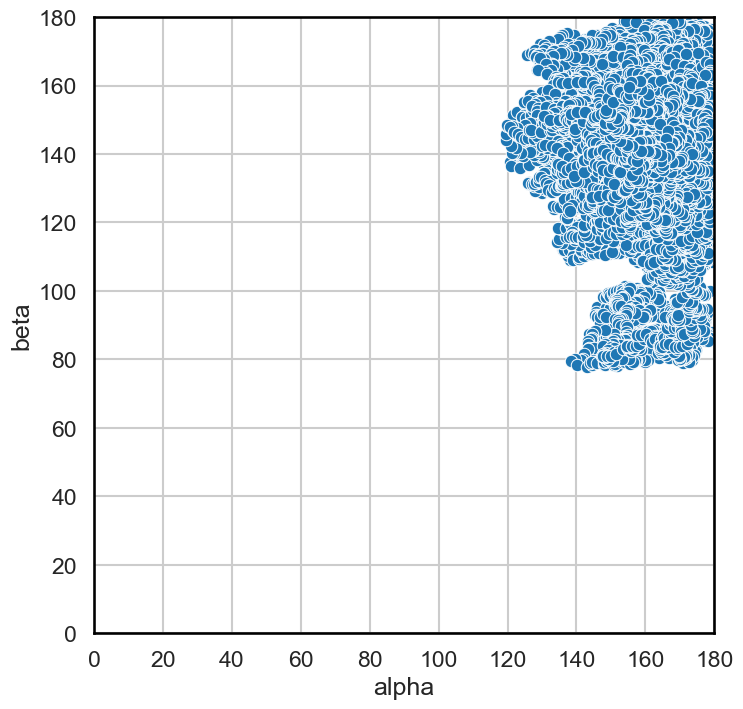

In [13]:
"""
The figures are being created here.
Look at sns.****plot(data=new_df, x="...", y="...") It says what your x and y is, taken from new_df Dataframe.
There are a lot of other options, like color, labels etc., just check at seaborn website "https://seaborn.pydata.org/api.html"

plt.xlim or plt.ylim set the limits on the graphs, you can change them if you need to "zoom in"

plt.gcf().set_size_inches() sets the size for the figure 

plt.savefig saves it. It will overwrite the file if it exists.
"""


sns.set_context("talk")
sns.set_style("whitegrid", {"axes.edgecolor": "black"})
sns.scatterplot(data=new_df, x="alpha", y="beta")
plt.xlim(0, 180)
plt.ylim(0, 180)
plt.gcf().set_size_inches(8, 8)


    
plt.savefig('scatter_full.png', dpi=600)

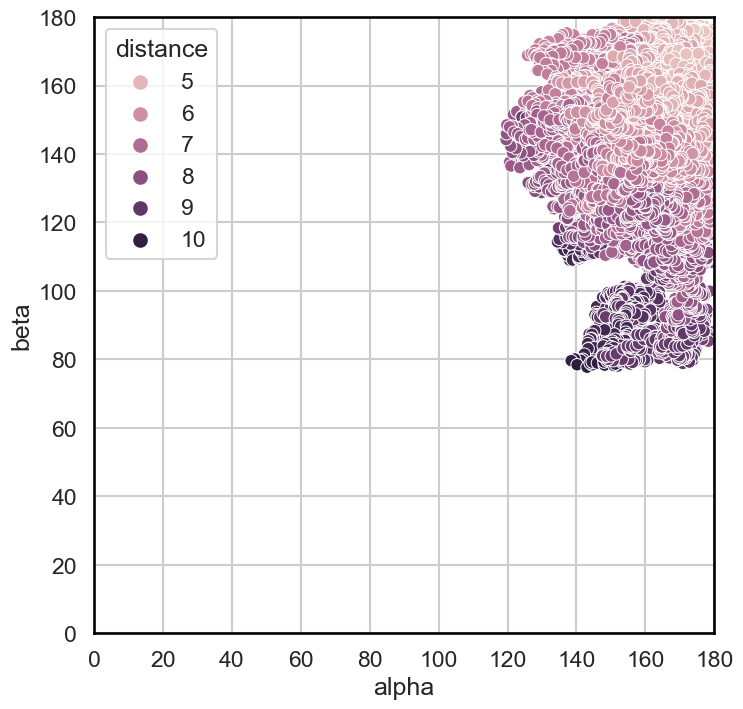

In [14]:


sns.scatterplot(data=new_df, x="alpha", y="beta", hue="distance")
plt.xlim(0, 180)
plt.ylim(0, 180)
plt.gcf().set_size_inches(8, 8)


plt.savefig('scatter_hue.png', dpi=600)


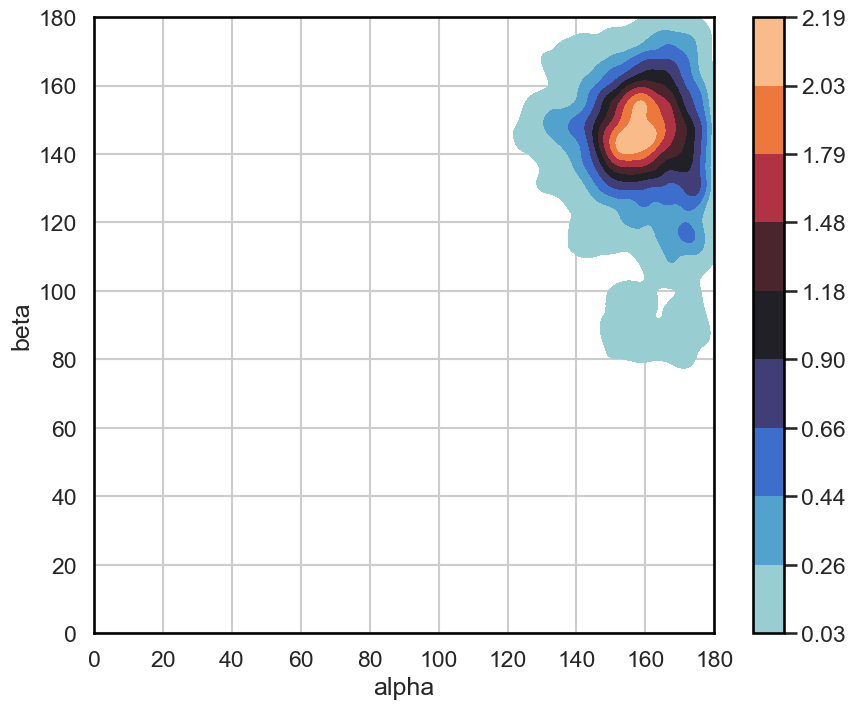

In [15]:
"""
FuncFormatter is just a fancy way to ensure that the numbers are correct and not rounded 
More interesting is kdeplot from seaborn. It has its own math module that calculates the kernel density and plots it. Check the website,
there are other nice ways to visualize the distributions.
"""

from matplotlib.ticker import FuncFormatter

fmt = lambda x,pos: '{:.2f}'.format(x*2000)
sns.kdeplot(data=new_df, x="alpha", y="beta", cmap="icefire", fill=True, thresh=0.01, cbar=True, cbar_kws={'format': FuncFormatter(fmt)})
plt.xlim(0, 180)
plt.ylim(0, 180)
plt.gcf().set_size_inches(10, 8)


    
plt.savefig('heat_full.png', dpi=600)

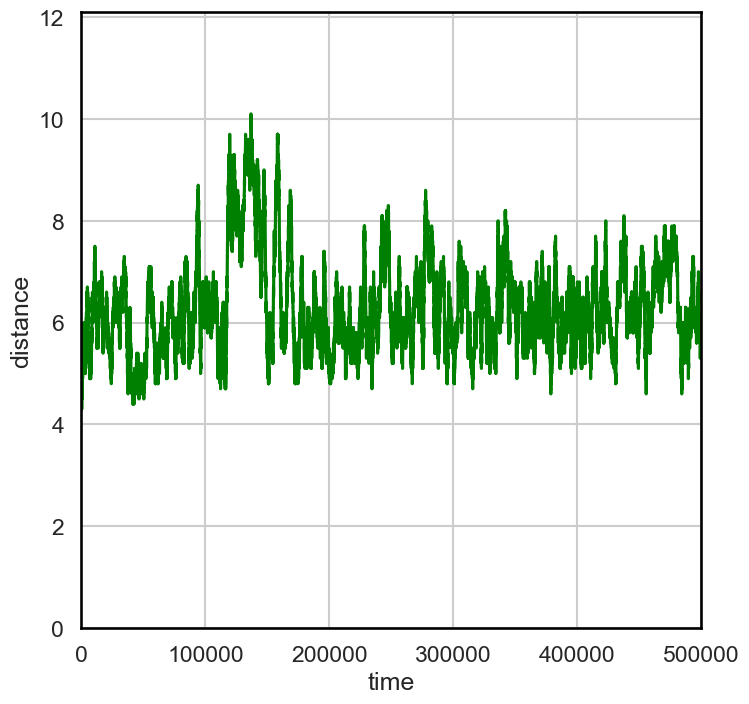

In [16]:
sns.lineplot(data=new_df, x="time", y="distance", color='g')
plt.xlim(0, new_df['time'].max())
plt.ylim(0, max_dist)



plt.gcf().set_size_inches(8, 8)


plt.savefig('line_full.png', dpi=600)


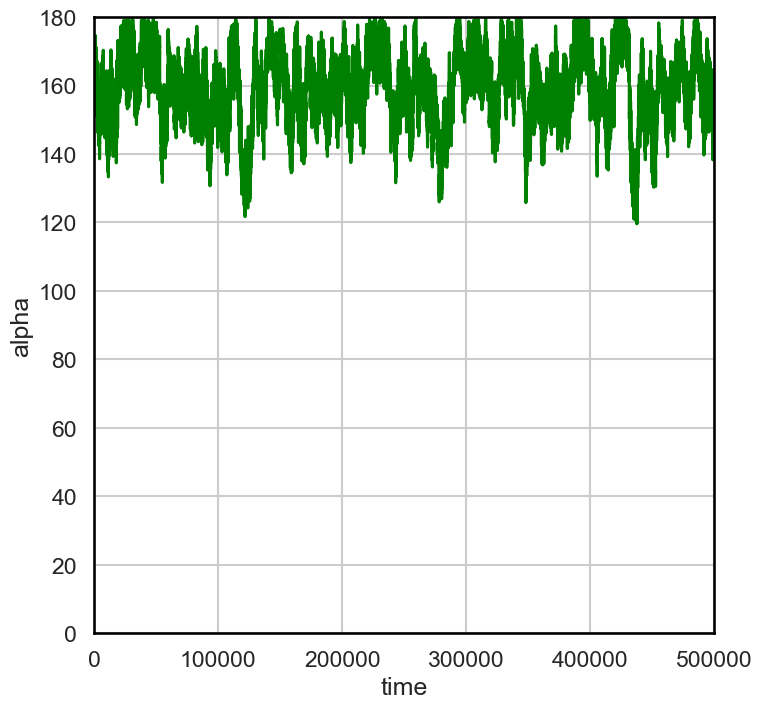

In [19]:
sns.lineplot(data=new_df, x="time", y="alpha", color='g')
plt.xlim(0, new_df['time'].max())
plt.ylim(0, 180)


plt.gcf().set_size_inches(8, 8)


    
plt.savefig('alpha_full.png', dpi=600)

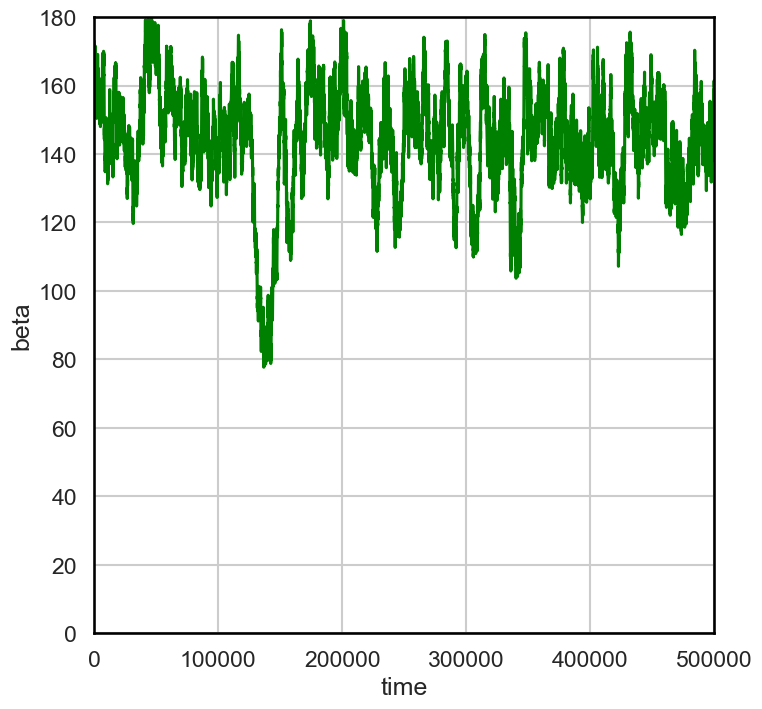

In [20]:
sns.lineplot(data=new_df, x="time", y="beta", color='g')
plt.xlim(0, new_df['time'].max())
plt.ylim(0, 180)


plt.gcf().set_size_inches(8, 8)


    
plt.savefig('beta_full.png', dpi=600)

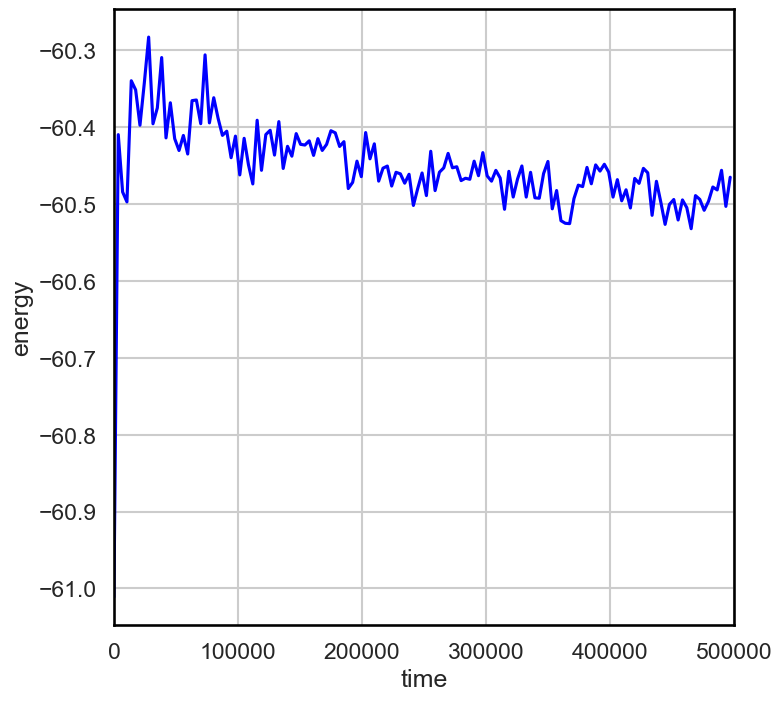

In [22]:
sns.lineplot(data=new_df, x="time", y="energy", color='b')
plt.xlim(0, new_df['time'].max())



plt.gcf().set_size_inches(8, 8)


    
plt.savefig('energy_full.png', dpi=600)